#Enhancing Radiological Diagnoses through Pattern Imaging Analytics

##Introduction

In the field of medical imaging, accuracy and early disease diagnosis are critical goals. Our initiative aims to improve radiological diagnosis by using machine learning advances to interpret complex patterns found in medical images. The ultimate goal is to identify non-obtrusive indicators of various medical conditions in order to enhance the precision and effectiveness of radiological evaluations.

Utilizing an abundance of radiographic imaging datasets, most notably the vast collection housed within the National Institutes of Health Clinical Center, we aim to develop advanced algorithms capable of detecting early indications of anomalies in a variety of critical organs, including the brain, lungs, and breasts. Through the integration of segmentation and pattern recognition techniques, our goal is to improve disease tracking systems and achieve previously unattainable levels of diagnostic accuracy.

We focus on utilizing machine learning to transform diagnostic paradigms since we recognize the intrinsic difficulties ingrained in traditional radiological methods, which range from subjectivity to error proneness. By utilizing pattern imaging analytics, we want to overcome the constraints of conventional methods and usher in a new era of precision and effectiveness in diagnosis.

The foundation of our project is the thorough compilation of an extensive dataset from various medical facilities, which we have gathered from start to finish. Our dataset, which is anchored by more than 100,000 anonymised chest x-ray pictures from a patient cohort of more than 30,000, is a powerful source of information that could lead to significant advancements in the field of medical imaging.

Our ambitions are in line with the overall objective of improving radiological diagnosis by using machine learning techniques sparingly as we set out on this revolutionary adventure. We continue to be unwavering in our commitment to improving patient outcomes and bringing in a new era of precision medicine because we acknowledge the critical role that technology is playing in changing the face of healthcare.

In [35]:
import os
import shutil
import urllib.request
import tarfile
from pathlib import Path

import pandas as pd
import cv2
from matplotlib import pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization


In [ ]:
# downloading the Data:



# URLs for the zip files
links = [
    'https://nihcc.box.com/shared/static/vfk49d74nhbxq3nqjg0900w5nvkorp5c.gz',
    'https://nihcc.box.com/shared/static/i28rlmbvmfjbl8p2n3ril0pptcmcu9d1.gz',
    'https://nihcc.box.com/shared/static/f1t00wrtdk94satdfb9olcolqx20z2jp.gz',
	'https://nihcc.box.com/shared/static/0aowwzs5lhjrceb3qp67ahp0rd1l1etg.gz',
    'https://nihcc.box.com/shared/static/v5e3goj22zr6h8tzualxfsqlqaygfbsn.gz',
	'https://nihcc.box.com/shared/static/asi7ikud9jwnkrnkj99jnpfkjdes7l6l.gz',
	'https://nihcc.box.com/shared/static/jn1b4mw4n6lnh74ovmcjb8y48h8xj07n.gz',
    'https://nihcc.box.com/shared/static/tvpxmn7qyrgl0w8wfh9kqfjskv6nmm1j.gz',
	'https://nihcc.box.com/shared/static/upyy3ml7qdumlgk2rfcvlb9k6gvqq2pj.gz',
	'https://nihcc.box.com/shared/static/l6nilvfa9cg3s28tqv1qc1olm3gnz54p.gz',
	'https://nihcc.box.com/shared/static/hhq8fkdgvcari67vfhs7ppg2w6ni4jze.gz',
	'https://nihcc.box.com/shared/static/ioqwiy20ihqwyr8pf4c24eazhh281pbu.gz'
]

for idx, link in enumerate(links):
    fn = 'images_%02d.tar.gz' % (idx+1)
    print('downloading'+fn+'...')
    urllib.request.urlretrieve(link, fn)  # download the zip file

print("Download complete. Please check the checksums")

In [ ]:
# unzipping the files and extracting the images:


def extract_images(tar_gz_path, output_folder):
    """
    Extracts image files from a .tar.gz archive to a specified folder.

    Args:
    tar_gz_path (str): The path to the .tar.gz file.
    output_folder (str): The directory to extract the images to.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Open the .tar.gz file
    with tarfile.open(tar_gz_path, 'r:gz') as file:
        # Iterate through its members
        for member in file.getmembers():
            # Check if the file looks like an image
            if member.isreg() and member.name.lower().endswith(('.png')):
                # Extract the member to the output directory
                file.extract(member, output_folder)
                print(f'Extracted {member.name} to {output_folder}')

ls = ['images_01.tar.gz','images_02.tar.gz','images_03.tar.gz','images_04.tar.gz','images_05.tar.gz','images_06.tar.gz','images_07.tar.gz','images_08.tar.gz','images_09.tar.gz','images_10.tar.gz','images_11.tar.gz','images_12.tar.gz']
output_folder = 'Ext_data'
for i in ls:
    extract_images(i, output_folder)


In [25]:
df = pd.read_csv('/Users/dhruv/Desktop/Dhruv /aml project/Final-v1/Data_Entry_2017_v2020.csv',low_memory=False)

In [26]:
df.head()


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168


In [4]:
folder_path = 'Data/'
files = os.listdir(folder_path)
image_names = []

In [5]:
for file_name in files:
    full_path = os.path.join(folder_path, file_name)
    if os.path.isfile(full_path):
        image_names.append(file_name)

In [6]:
print(len(image_names))

15000


In [37]:
label = []
for i in df['Finding Labels']:
  result = i.split('|')
  label.append(result[0])
df['Updated_Label'] = label
x = df['Image Index']

In [39]:
df['Updated_Label']

0         Cardiomegaly
1         Cardiomegaly
2         Cardiomegaly
3           No Finding
4               Hernia
              ...     
112115            Mass
112116      No Finding
112117      No Finding
112118      No Finding
112119      No Finding
Name: Updated_Label, Length: 112120, dtype: object

In [8]:
pred_label = []

In [9]:
for image_name in image_names:
    if image_name in df['Image Index'].values:
        # Get the corresponding label for the image
        label = df[df['Image Index'] == image_name]['Updated_Label'].iloc[0]
        # Append the label to the list
        pred_label.append(label)


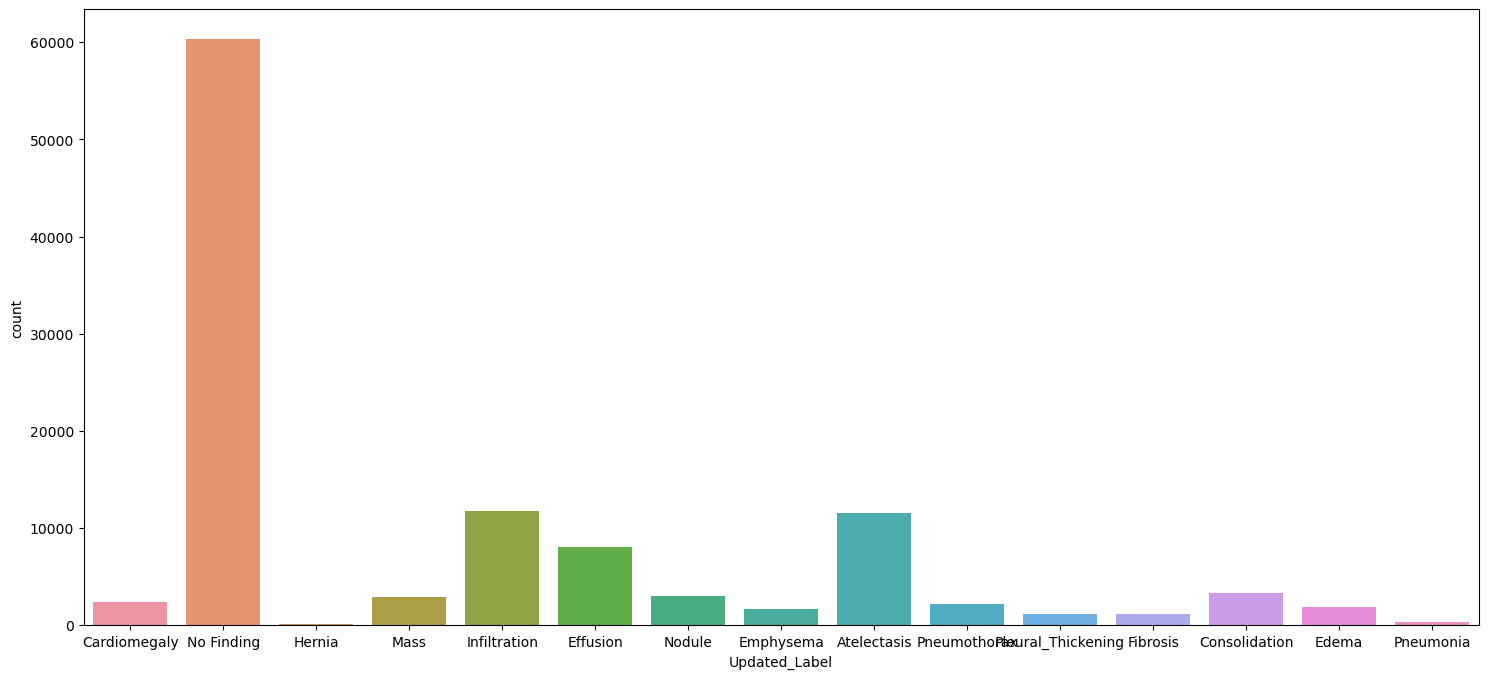

In [11]:

plt.figure(figsize=(18, 8))
sns.countplot(x='Updated_Label', data=df)
plt.show()

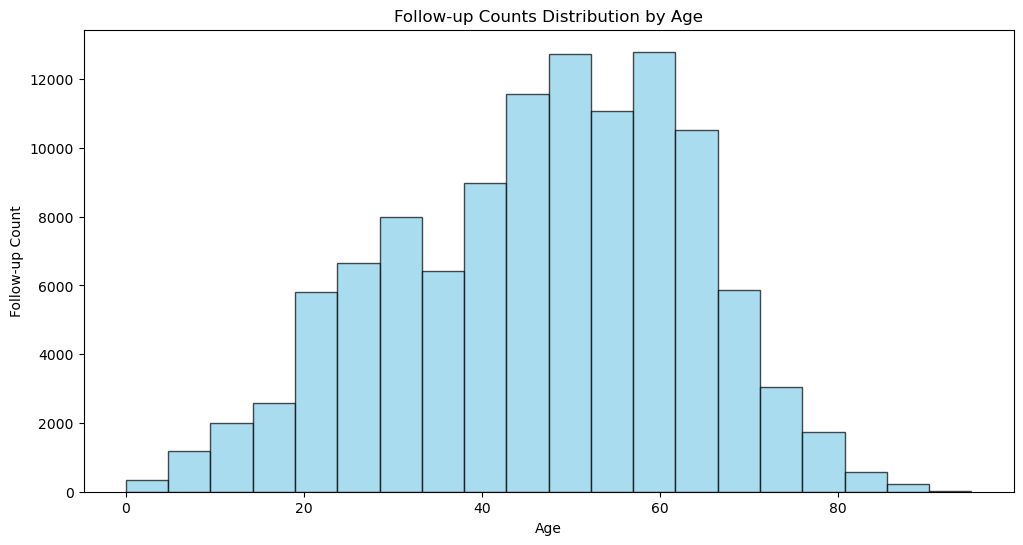

In [12]:
#follow up counts by age

df['Patient ID'] = pd.to_numeric(df['Patient ID'])
df['Patient Age'] = pd.to_numeric(df['Patient Age'])

# Calculate follow-up counts for each age
follow_up_counts = df.groupby('Patient Age')['Patient ID'].count()

# Plotting the histogram
plt.figure(figsize=(12, 6))
plt.hist(df['Patient Age'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Age')
plt.ylabel('Follow-up Count')
plt.title('Follow-up Counts Distribution by Age')
plt.show()


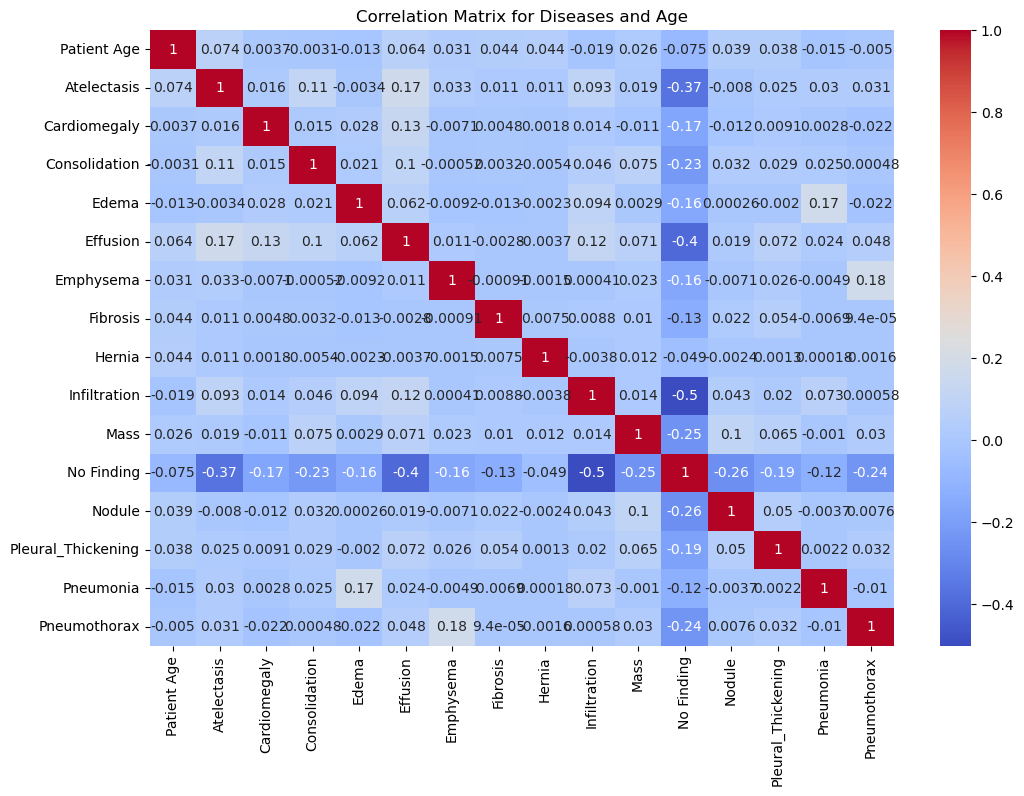

In [18]:
#correlation matrix between diseases and patient age in the given dataset

diseases_df = df['Upda'].str.get_dummies(sep='|')

# Concatenate the original DataFrame with the diseases DataFrame
df_extended = pd.concat([df, diseases_df], axis=1)

# Correlation matrix for diseases and age
corr_cols = ['Patient Age'] + list(diseases_df.columns)
diseases_age_corr = df_extended[corr_cols].corr()

# Plotting the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(diseases_age_corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Diseases and Age')
plt.show()


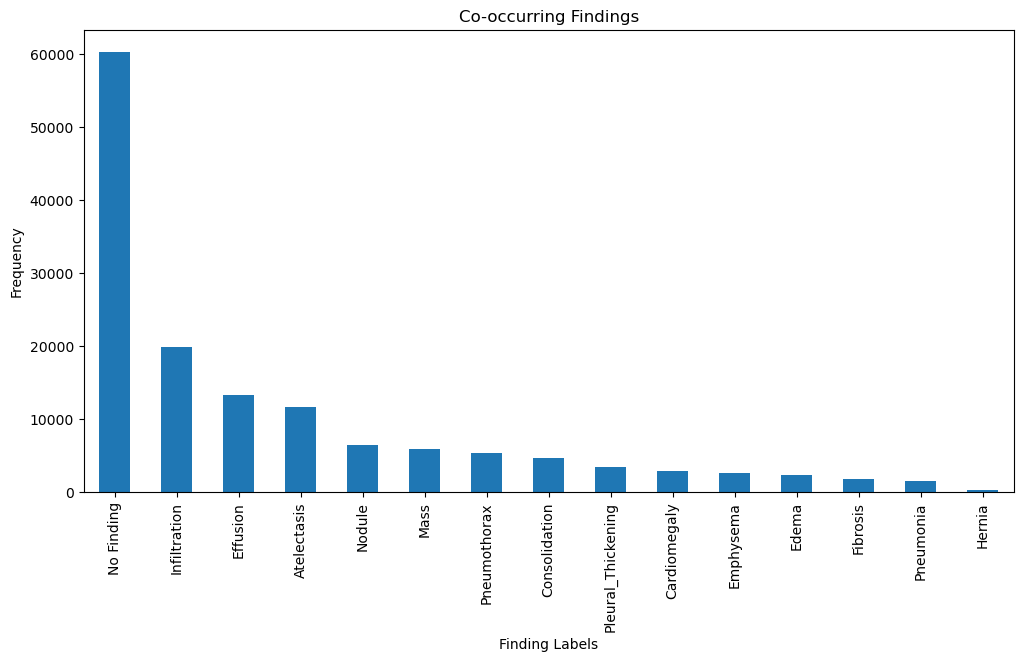

In [15]:
# Stacked bar chart for co-occurring findings
co_occurring_findings = df['Finding Labels'].str.get_dummies('|').sum().sort_values(ascending=False)
co_occurring_findings.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.xlabel('Finding Labels')
plt.ylabel('Frequency')
plt.title('Co-occurring Findings')
plt.show()

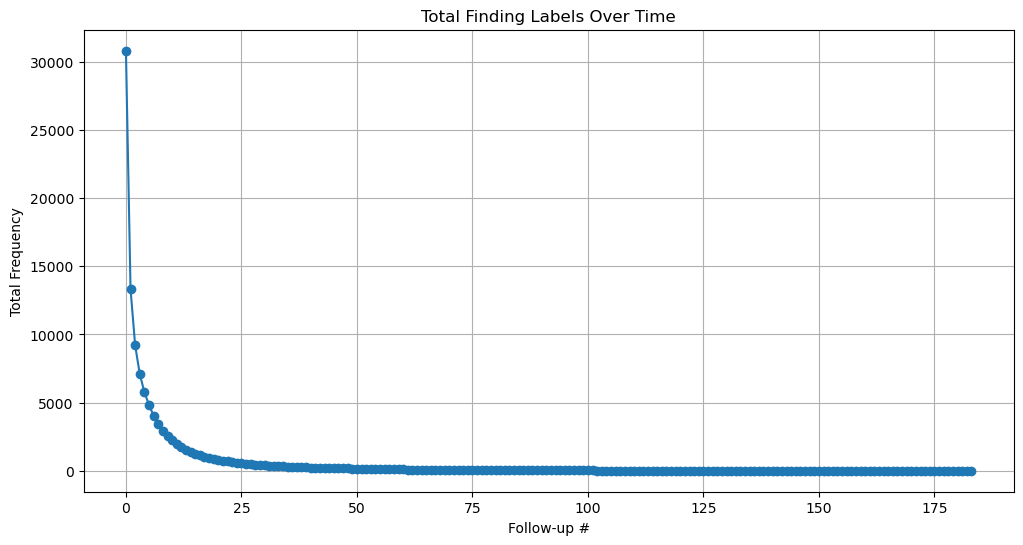

In [27]:

finding_labels_over_time = df.groupby('Follow-up #').size()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(finding_labels_over_time.index, finding_labels_over_time.values, marker='o')
plt.xlabel('Follow-up #')
plt.ylabel('Total Frequency')
plt.title('Total Finding Labels Over Time')
plt.grid(True)
plt.show()


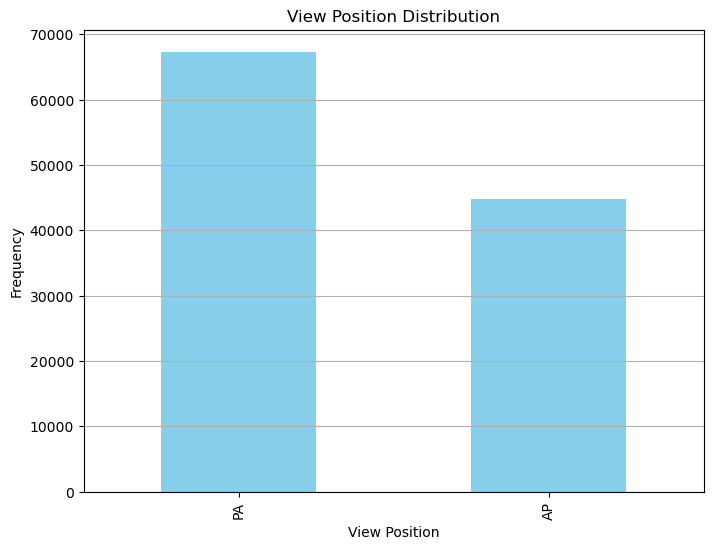

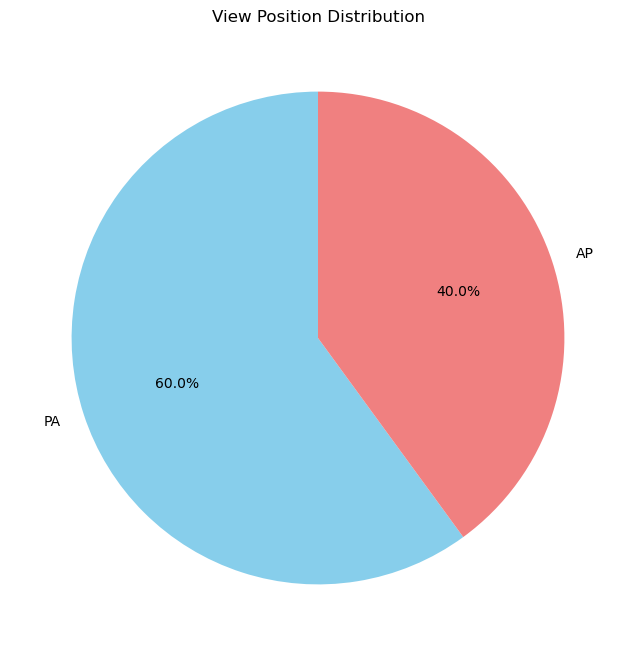

In [28]:


view_position_counts = df['View Position'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
view_position_counts.plot(kind='bar', color='skyblue')
plt.xlabel('View Position')
plt.ylabel('Frequency')
plt.title('View Position Distribution')
plt.grid(axis='y')
plt.show()

# Pie chart
plt.figure(figsize=(8, 8))
plt.pie(view_position_counts, labels=view_position_counts.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral'])
plt.title('View Position Distribution')
plt.show()


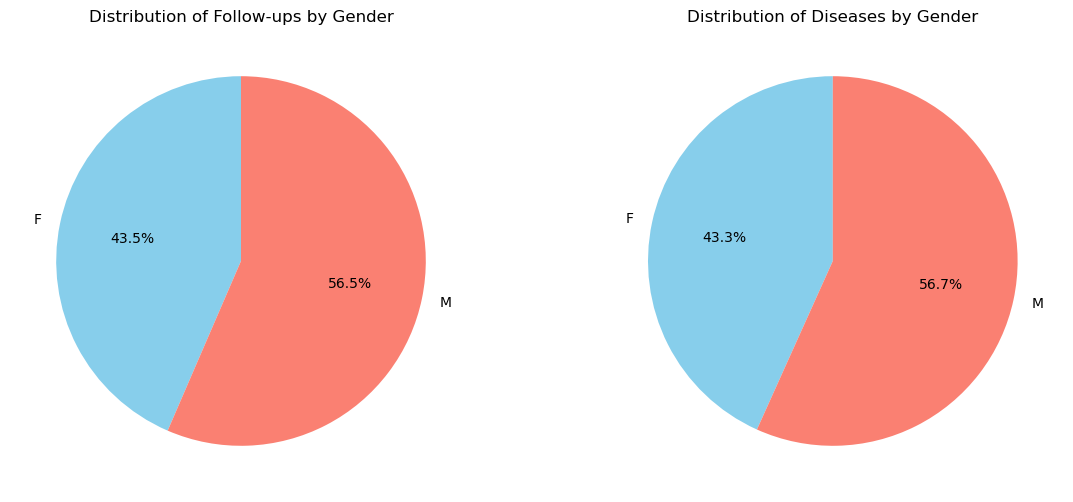

In [31]:
df['Patient ID'] = pd.to_numeric(df['Patient ID'])
df['Patient Age'] = pd.to_numeric(df['Patient Age'])

# Extracting relevant columns
data = df[['Patient Gender', 'Follow-up #', 'Finding Labels']]

# Calculating follow-up counts by gender
follow_up_counts = data.groupby('Patient Gender')['Follow-up #'].count()

# Calculating disease counts by gender
disease_counts = data['Finding Labels'].str.split('|').explode().groupby(data['Patient Gender']).count()

# Plotting the pie charts
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Pie chart for follow-ups by gender
axs[0].pie(follow_up_counts, labels=follow_up_counts.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'salmon'])
axs[0].set_title('Distribution of Follow-ups by Gender')

# Pie chart for diseases by gender
axs[1].pie(disease_counts, labels=disease_counts.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'salmon'])
axs[1].set_title('Distribution of Diseases by Gender')

plt.show()

In [ ]:
def organize_images_by_labels(image_folder, image_filenames, labels, output_folder):
    if not os.path.exists(output_folder):
        os.mkdir(output_folder)

    # Create a set of unique labels 
    unique_labels = set(labels)
    for label in unique_labels:
        label_folder = os.path.join(output_folder, str(label))
        if not os.path.exists(label_folder):
            os.mkdir(label_folder)

    # Loop through all images and their corresponding labels
    for filename, label in zip(image_filenames, labels):
        # Define the source and destination paths
        src_path = os.path.join(image_folder, filename)
        dest_path = os.path.join(output_folder, str(label), filename)

        # Move the image if it exists
        if os.path.isfile(src_path):
            shutil.move(src_path, dest_path)
        else:
            print(f"Warning: {src_path} does not exist and cannot be moved.")

In [ ]:
# Usage example
image_folder = '/Users/dhruv/Desktop/Dhruv /aml project/Final-v1/BlurData'  # Path where your images are currently stored
output_folder = 'Img_data'  # Path where you want to organize images by label
image_filenames = [f for f in os.listdir(image_folder) if f.endswith('.png')]  # List of image files, ensure these are correctly named and exist
# Your list of labels, must be aligned with `image_filenames`

In [ ]:
organize_images_by_labels(image_folder, image_filenames, pred_label, output_folder)

In [ ]:
# Initialize the ImageDataGenerator with data preprocessing and augmentation options
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values from 0-255 to 0-1
    width_shift_range=0.2,  # Random horizontal shifts
    height_shift_range=0.2,  # Random vertical shifts
    shear_range=0.2,  # Shear transformations
    horizontal_flip=True,  # Random horizontal flips
    fill_mode='nearest'  # Strategy to fill newly created pixels after a rotation or shift
)

In [ ]:
# Set the path to your main directory containing the subfolders
base_dir = 'Img_Data'

In [ ]:
# Create generators
train_generator = datagen.flow_from_directory(
    directory=base_dir,  # Path to the data directory
    target_size=(256, 256),  # Resizes all images to 256x256 pixels
    batch_size=32,
    class_mode='categorical',  # For multi-class classification
    shuffle=True  # Shuffle the order of images
)

Found 14999 images belonging to 15 classes.


In [33]:

def create_cnn_models(input_shape, num_classes, activation_functions=['tanh', 'sigmoid', 'relu'], num_blocks=[3, 4, 5]):
    models = []
    for blocks in num_blocks:
        for activation in activation_functions:
            model = Sequential()
            # Dynamic addition of convolutional blocks based on the number of blocks specified
            for i in range(blocks):
                if i == 0:
                    # First block with 32 filters
                    filters = 16
                elif i == 1:
                    # Second block with 64 filters
                    filters = 32
                elif i == 2:
                    # Third block with 128 filters
                    filters = 64
                elif i == 3:
                    # Fourth block with 256 filters
                    filters = 128
                elif i == 4:
                    # Fifth block with 512 filters
                    filters = 256
                elif i == 5:
                    # sixth block with 512 filters
                    filters = 512


                # Add Conv2D layer
                if i == 0:
                    model.add(Conv2D(filters, (3, 3), padding='same', activation=activation, input_shape=input_shape))
                else:
                    model.add(Conv2D(filters, (3, 3), padding='same', activation=activation))

                # Common layers after each Conv2D
                model.add(BatchNormalization())
                model.add(MaxPooling2D(pool_size=(2, 2)))
                model.add(Dropout(0.25))

            # Flatten and Dense Layers
            model.add(Flatten())
            model.add(Dense(256, activation=activation))
            model.add(Dropout(0.5))
            model.add(Dense(num_classes, activation='softmax'))

            # Compile model
            model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
            models.append(model)

    return models

Experiment 1

In [ ]:
model1 = create_cnn_model(input_shape, num_classes, 'tanh', 3)
print("Experiment 1: Model with 3 blocks and 'tanh' activation created.")


In Experiment 1, a CNN model with 3 blocks and 'tanh' activation function was created. The model architecture, comprising convolutional and pooling layers, awaits training and evaluation. Insights include the impact of activation functions on performance and the balance between model complexity and learning capacity. Future directions involve experimenting with different activations, optimization techniques, and diverse datasets to enhance generalization and performance.

Experiment 2

In [ ]:
model2 = create_cnn_model(input_shape, num_classes, 'tanh', 4)
print("Experiment 2: Model with 4 blocks and 'tanh' activation created.")


Experiment 2 introduces a Convolutional Neural Network (CNN) model with 4 blocks and 'tanh' activation. Its architecture, like Experiment 1, involves convolutional layers. Performance evaluation remains pending. Insights include increased complexity and consistency in activation function usage. Future steps involve performance evaluation, hyperparameter tuning, and comparative analysis to refine understanding and enhance effectiveness.

Experiment 3

In [ ]:
model3 = create_cnn_model(input_shape, num_classes, 'tanh', 5)
print("Experiment 3: Model with 5 blocks and 'tanh' activation created.")


Here a model with five blocks and the 'tanh' activation function is examined. This goes beyond what was done in earlier trials with the architecture, which might enable deeper understanding of intricate patterns. The model evaluation is still excellent, same like in previous generations. Using the 'tanh' activation function consistently allows for direct comparison with previous studies, which is noteworthy as it sheds light on the effects of architectural modifications while preserving activation uniformity. Subsequently, performance evaluation, hyperparameter adjustment, and comparative analysis will enhance understanding and improve the effectiveness of the model.

Experiment 4

In [ ]:
model4 = create_cnn_model(input_shape, num_classes, 'sigmoid', 3)
print("Experiment 4: Model with 3 blocks and 'sigmoid' activation created.")


By using the 'sigmoid' activation function, which tends to squeeze values into a range between 0 and 1, Experiment 4 introduces a notable deviation. This change results in subtle variations in the learning behavior of the model when compared to 'tanh'. For example, the 'sigmoid' activation may be more appropriate because of its output range for tasks involving binary categorization. Nevertheless, vanishing gradient problems could arise during training, which would affect the model's performance and convergence rate, particularly in deeper networks. Through an assessment of the model's performance, we may gain a deeper understanding of the relative efficacy of'sigmoid' versus 'tanh' activations inside CNN architectures. Furthermore, investigating the relationship between the activation function selection and the total number of blocks and architecture could yield important design insights for CNNs.

Experiment 5

In [ ]:
model5 = create_cnn_model(input_shape, num_classes, 'sigmoid', 4)
print("Experiment 5: Model with 4 blocks and 'sigmoid' activation created.")


Convolutional Neural Network (CNN) model with four blocks that uses the'sigmoid' activation function. The goal of this iteration is to further our comprehension of the relationship between architectural complexity and the selection of activation function. The incorporation of an extra block enhances the model's ability to represent complex patterns. Deeper architectures may have difficulties due to the'sigmoid' activation function's propensity to saturate gradients, which could have an impact on convergence and performance. An assessment of performance is required to determine the effects of these architectural modifications. The knowledge gathered from this experiment will help to refine our understanding of the function of activation functions in CNN architectures and how they affect model performance. Future model design selections will be guided by the efficiency of'sigmoid' activation in various architectural contexts, which will be revealed through further analysis and comparison with earlier trials.

Experiment 6

In [ ]:
model6 = create_cnn_model(input_shape, num_classes, 'sigmoid', 5)
print("Experiment 6: Model with 5 blocks and 'sigmoid' activation created.")


In experiment 6 we created a five-block model using the'sigmoid' activation function. The purpose of this experiment is to further our understanding of how architectural complexity and activation functions interact. We improve the model's ability to memorize intricate patterns by expanding it to five blocks. Nonetheless, the selection of'sigmoid' activation could present difficulties because of its propensity for gradient saturation, especially in deeper topologies. To evaluate how well the model can learn and generalize, performance evaluation is crucial. The results of this experiment will shed light on whether "sigmoid" activation is appropriate for deep CNN architectures and how it affects model performance. The impact of activation functions in influencing neural network behavior will be better clarified and future model design decisions will be guided by comparative analysis with prior experiments.

Experiment 7

In [ ]:
model7 = create_cnn_model(input_shape, num_classes, 'relu', 3)
print("Experiment 7: Model with 3 blocks and 'relu' activation created.")


Using the 'ReLU' (Rectified Linear Unit) activation function, Experiment 7 presents a three-block Convolutional Neural Network (CNN) model. 'ReLU', a popular activation function well-known for its efficiency in deep neural networks, is employed in this experiment, which differs from earlier ones. The architecture is probably composed of convolutional layers, 'ReLU' activation, and maybe pooling or other processes in between. ReLU activation allows only positive values to pass through, avoiding problems such as vanishing gradients and speeding up convergence. To determine whether the model is capable of learning intricate patterns and extrapolating to previously unknown data, performance evaluation is required. The knowledge gathered from this experiment will help us better understand how 'ReLU' activation affects CNN architectures and direct future research into how successful it is in comparison to other activation functions.Furthermore, comparing models with varying activation functions will shed light on how activation functions affect the functionality and behavior of neural networks.

Experiment 8

In [ ]:
model8 = create_cnn_model(input_shape, num_classes, 'relu', 4)
print("Experiment 8: Model with 4 blocks and 'relu' activation created.")


Using a Convolutional Neural Network (CNN) model with four blocks and the 'ReLU' (Rectified Linear Unit) activation function, Experiment 8 expands on the investigation of activation functions. The rationale behind selecting "ReLU" is its ability to mitigate the vanishing gradient issue and accelerate the convergence of deep neural networks. It is likely that the architecture consists of convolutional layers followed by 'ReLU' activation, with pooling or other processes added as needed. Increasing the number of blocks gives the model the ability to pick up intricate patterns. To evaluate the model's convergence behavior and generalizability, performance evaluation is crucial. The knowledge gained from this experiment will help us better understand the effects of 'ReLU' activation in CNN architectures and guide the development of new models.

Experiment 9

In [ ]:
model9 = create_cnn_model(input_shape, num_classes, 'relu', 5)
print("Experiment 9: Model with 5 blocks and 'relu' activation created.")


Activation functions are further explored in Experiment 9 using a Convolutional Neural Network (CNN) model with five blocks and 'ReLU' (Rectified Linear Unit) activation. The purpose of this version is to investigate the relationship between 'ReLU' activation and more sophisticated architecture. Deep neural networks are well suited for "ReLU," since it can expedite convergence and resolve vanishing gradient problems. It is likely that the model consists of convolutional layers followed by 'ReLU' activation, with pooling or other procedures added as needed. Extending the model to five blocks increases its ability to identify complex patterns in the data.
To evaluate the model's convergence behavior and capacity for generalization, performance evaluation is essential. The experiment will yield useful insights that will enhance our comprehension of the ramifications of 'ReLU' activation in CNN architectures and offer crucial direction for future model design decisions. The relative efficacy of 'ReLU' will be clarified and the selection of activation functions for neural network models will be informed by a comparative comparison with prior experiments using other activation functions.


Experiment 10

In [ ]:
model10 = create_cnn_model(input_shape, num_classes, 'relu', 2)
print("Experiment 10: Model with 2 blocks and 'relu' activation created.")


In Experiment 10, two blocks and "Rectified Linear Unit" (ReLU) activation are used to investigate the effects of reduced architectural complexity on a Convolutional Neural Network (CNN) model. In contrast to earlier studies, this one seeks to determine how the quantity of blocks influences the model's ability to learn and its overall performance. The "ReLU" activation is selected because it effectively addresses gradient vanishing problems, which are critical for deeper networks. Most likely, pooling or other procedures are added to the model architecture after 'ReLU' activation, which comes after convolutional layers. The model's complexity is reduced when the number of blocks is reduced, which may have an impact on the model's capacity to capture complicated patterns. The model's convergence behavior and capacity for generalization will be revealed through performance evaluation.
The results of this experiment will help shape future decisions about model design by providing a deeper knowledge of the relationship between architectural complexity, activation functions, and model performance. Further clarification of the trade-offs and factors to be taken into account in CNN architecture design will come from a comparative study with earlier experiments that used various block counts and activation functions.


Experiment 11

In [ ]:
model11 = create_cnn_model(input_shape, num_classes, 'sigmoid', 6)
print("Experiment 11: Model with 6 blocks and 'sigmoid' activation created.")


With a model with six blocks and "sigmoid" activation, Experiment 11 explores unknown ground in an attempt to gain a deeper understanding of the complex link between activation functions and architectural complexity. We provide the model an extended canvas to capture subtle patterns in the data by expanding it to six blocks. Nevertheless, there are interesting issues associated with the choice to use'sigmoid' activation in this deeper design. The typical squashing effect of the'sigmoid' activation may impede gradient propagation during training, hence hindering convergence and compromising overall performance. Furthermore, the possibility of running into vanishing gradients is increased in deeper structures, therefore this needs to be carefully considered.
Performance assessment will act as a yardstick, exposing the flexibility and generalizability of the methodology. The results of this experiment should provide more understanding of the complex dynamics of activation functions in CNN architectures and be a significant resource for fine-tuning model design decisions. We want to untangle the complex trade-offs involved in neural network architecture selection through comparison analysis, especially versus experiments with different activation functions and block counts, opening the door to more intelligent and efficient model creation procedures.



Experiment 12

In [ ]:
model12 = create_cnn_model(input_shape, num_classes, 'tanh', 6)
print("Experiment 12: Model with 6 blocks and 'tanh' activation created.")


Experiment 12 delves further into the architectures of Convolutional Neural Networks (CNNs) using six blocks and 'tanh' activation. The goal of this project is to provide deep understanding of the relationship between architectural depth and activation functions. We give the model the power to extract complex features from the data by expanding it to six blocks. The model's learning dynamics gain subtlety from the addition of the 'tanh' activation function, which is renowned for its saturation qualities and centered output around zero. Nevertheless, the 'tanh' activation might face difficulties in deeper structures, such disappearing gradients, which could impair convergence and overall performance.
Assessing the model's performance becomes crucial for determining its adaptability and generalizability. The results of this experiment should contribute to our understanding of how activation functions influence CNN architectural behavior, providing crucial direction for improving model building techniques. We seek to reveal the complex trade-offs involved in neural network architecture selection by thorough comparative analyses, particularly versus trials using varying activation functions and block counts, paving the way towards more reliable and efficient model building.


####Summary of the models

In [ ]:
input_shape = (256, 256, 3)  # Example input shape 
num_classes = 15  # Example number of classes

# Generate the models
models = create_cnn_models(input_shape, num_classes)

# Iterate over each model and print its configuration
for i, model in enumerate(models):
    print(f"Model {i+1}:")
    model.summary()
    print("\n---\n")


/Users/dhruv/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model 1:


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_41 (Conv2D)              │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 256, 256, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 256)            │    16,777,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,805,359 (64.11 MB)

 Trainable params: 16,805,135 (64.11 MB)

 Non-trainable params: 224 (896.00 B)


---

Model 2:


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_44 (Conv2D)              │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 256, 256, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_46 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │    16,777,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,805,359 (64.11 MB)

 Trainable params: 16,805,135 (64.11 MB)

 Non-trainable params: 224 (896.00 B)


---

Model 3:


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_47 (Conv2D)              │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 256, 256, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │    16,777,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,805,359 (64.11 MB)

 Trainable params: 16,805,135 (64.11 MB)

 Non-trainable params: 224 (896.00 B)


---

Model 4:


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_50 (Conv2D)              │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 256, 256, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_51          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_51 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_64 (Dropout)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_52          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_52 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_65 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_53          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_53 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_66 (Dropout)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_67 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,491,119 (32.39 MB)

 Trainable params: 8,490,639 (32.39 MB)

 Non-trainable params: 480 (1.88 KB)


---

Model 5:


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_54 (Conv2D)              │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_54          │ (None, 256, 256, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_54 (MaxPooling2D) │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_68 (Dropout)            │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_55          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_55 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_69 (Dropout)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_56          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_56 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_70 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_57          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_57 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_71 (Dropout)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_72 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,491,119 (32.39 MB)

 Trainable params: 8,490,639 (32.39 MB)

 Non-trainable params: 480 (1.88 KB)


---

Model 6:


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_58 (Conv2D)              │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_58          │ (None, 256, 256, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_58 (MaxPooling2D) │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_73 (Dropout)            │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_59          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_59 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_74 (Dropout)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_60          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_60 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_75 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_61          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_61 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_76 (Dropout)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_77 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,491,119 (32.39 MB)

 Trainable params: 8,490,639 (32.39 MB)

 Non-trainable params: 480 (1.88 KB)


---

Model 7:


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_62 (Conv2D)              │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_62          │ (None, 256, 256, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_62 (MaxPooling2D) │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_78 (Dropout)            │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_63          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_63 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_79 (Dropout)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_64          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_64 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_80 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_65          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_65 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_81 (Dropout)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_66 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_66          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_66 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_82 (Dropout)            │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 256)            │     4,194,560 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 4,593,007 (17.52 MB)

 Trainable params: 4,592,015 (17.52 MB)

 Non-trainable params: 992 (3.88 KB)


---

Model 8:


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_67 (Conv2D)              │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_67          │ (None, 256, 256, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_67 (MaxPooling2D) │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_84 (Dropout)            │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_68          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_68 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_85 (Dropout)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_69 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_69          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_69 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_86 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_70 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_70          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_70 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_87 (Dropout)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_71 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_71          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_71 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_88 (Dropout)            │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 256)            │     4,194,560 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 4,593,007 (17.52 MB)

 Trainable params: 4,592,015 (17.52 MB)

 Non-trainable params: 992 (3.88 KB)


---

Model 9:


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_72 (Conv2D)              │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_72          │ (None, 256, 256, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_72 (MaxPooling2D) │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_90 (Dropout)            │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_73 (Conv2D)              │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_73          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_73 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_91 (Dropout)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_74 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_74          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_74 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_92 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_75 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_75          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_75 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_93 (Dropout)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_76 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_76          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_76 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_94 (Dropout)            │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 256)            │     4,194,560 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 4,593,007 (17.52 MB)

 Trainable params: 4,592,015 (17.52 MB)

 Non-trainable params: 992 (3.88 KB)


---



In [ ]:
# Start training the model
history = model.fit(
    train_generator,
    steps_per_epoch=150,  # depends on the size of your training set
    epochs=10)  # number of complete passes through the dataset  # depends on your validation set size


In [ ]:
for i in range(train_generator.samples // train_generator.batch_size):
    x_batch, y_batch = next(train_generator)
    # Optionally, you could add checks or visualizations here


In [ ]:
hist = []
for i, model in enumerate(models):
    history = model.fit(
        train_generator,
        steps_per_epoch=149,
        epochs=6,
        verbose=1  # Add verbose for real-time training progress
    )
    hist.append(history)


Epoch 1/6
149/149 ━━━━━━━━━━━━━━━━━━━━ 127s 810ms/step - accuracy: 0.0785 - loss: 3.6467
Epoch 2/6
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 39us/step - accuracy: 0.0312 - loss: 1.6102   
Epoch 3/6


2024-04-22 22:49:19.588434: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


149/149 ━━━━━━━━━━━━━━━━━━━━ 126s 811ms/step - accuracy: 0.0830 - loss: 3.1859
Epoch 4/6
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 21us/step - accuracy: 0.1250 - loss: 1.5391   
Epoch 5/6


2024-04-22 22:51:25.961954: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


149/149 ━━━━━━━━━━━━━━━━━━━━ 137s 889ms/step - accuracy: 0.0997 - loss: 3.0069
Epoch 6/6
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 22us/step - accuracy: 0.1250 - loss: 1.4638   


2024-04-22 22:53:43.758239: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Epoch 1/6
149/149 ━━━━━━━━━━━━━━━━━━━━ 143s 916ms/step - accuracy: 0.1008 - loss: 3.1460
Epoch 2/6
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 38us/step - accuracy: 0.0938 - loss: 1.3857   
Epoch 3/6


2024-04-22 22:56:08.485618: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


149/149 ━━━━━━━━━━━━━━━━━━━━ 140s 911ms/step - accuracy: 0.0993 - loss: 2.8211
Epoch 4/6
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 21us/step - accuracy: 0.0938 - loss: 1.4373   
Epoch 5/6


2024-04-22 22:58:29.497864: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


149/149 ━━━━━━━━━━━━━━━━━━━━ 141s 918ms/step - accuracy: 0.0919 - loss: 2.7815
Epoch 6/6
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 21us/step - accuracy: 0.1250 - loss: 1.4790   


2024-04-22 23:00:51.529306: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Epoch 1/6
149/149 ━━━━━━━━━━━━━━━━━━━━ 143s 925ms/step - accuracy: 0.1007 - loss: 11.2327
Epoch 2/6
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 34us/step - accuracy: 0.0312 - loss: 1.3417   
Epoch 3/6


2024-04-22 23:03:16.720093: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


149/149 ━━━━━━━━━━━━━━━━━━━━ 135s 877ms/step - accuracy: 0.1105 - loss: 2.6692
Epoch 4/6
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 22us/step - accuracy: 0.0312 - loss: 1.3240   
Epoch 5/6


2024-04-22 23:05:32.747393: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


149/149 ━━━━━━━━━━━━━━━━━━━━ 146s 951ms/step - accuracy: 0.0996 - loss: 2.6377
Epoch 6/6
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 21us/step - accuracy: 0.0625 - loss: 1.3162   


2024-04-22 23:07:59.756988: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Epoch 1/6
149/149 ━━━━━━━━━━━━━━━━━━━━ 146s 945ms/step - accuracy: 0.0951 - loss: 3.8105
Epoch 2/6
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 40us/step - accuracy: 0.1250 - loss: 1.7174   
Epoch 3/6


2024-04-22 23:10:28.149148: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


149/149 ━━━━━━━━━━━━━━━━━━━━ 146s 945ms/step - accuracy: 0.0830 - loss: 3.2059
Epoch 4/6
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 25us/step - accuracy: 0.0625 - loss: 1.4314   
Epoch 5/6


2024-04-22 23:12:54.426463: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


149/149 ━━━━━━━━━━━━━━━━━━━━ 145s 938ms/step - accuracy: 0.0943 - loss: 3.0300
Epoch 6/6
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 26us/step - accuracy: 0.0625 - loss: 1.5451   


2024-04-22 23:15:19.673097: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Epoch 1/6
149/149 ━━━━━━━━━━━━━━━━━━━━ 149s 959ms/step - accuracy: 0.0899 - loss: 2.9577
Epoch 2/6
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 39us/step - accuracy: 0.1250 - loss: 1.3228   
Epoch 3/6


2024-04-22 23:17:50.281148: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


149/149 ━━━━━━━━━━━━━━━━━━━━ 149s 965ms/step - accuracy: 0.0923 - loss: 2.7507
Epoch 4/6
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 22us/step - accuracy: 0.0625 - loss: 1.3824   
Epoch 5/6


2024-04-22 23:20:19.825600: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


149/149 ━━━━━━━━━━━━━━━━━━━━ 147s 952ms/step - accuracy: 0.0918 - loss: 2.7002
Epoch 6/6
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 23us/step - accuracy: 0.0312 - loss: 1.4792   


2024-04-22 23:22:47.120071: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Epoch 1/6
149/149 ━━━━━━━━━━━━━━━━━━━━ 146s 940ms/step - accuracy: 0.0976 - loss: 7.7627
Epoch 2/6
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 40us/step - accuracy: 0.1562 - loss: 1.3443   
Epoch 3/6


2024-04-22 23:25:14.887977: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


149/149 ━━━━━━━━━━━━━━━━━━━━ 146s 948ms/step - accuracy: 0.1025 - loss: 2.7241
Epoch 4/6
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 23us/step - accuracy: 0.1250 - loss: 1.3430   
Epoch 5/6


2024-04-22 23:27:41.585413: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


149/149 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - accuracy: 0.1005 - loss: 2.6372
Epoch 6/6
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 23us/step - accuracy: 0.0625 - loss: 1.3181   


2024-04-22 23:30:17.349513: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Epoch 1/6
149/149 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.0897 - loss: 3.9497
Epoch 2/6
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 43us/step - accuracy: 0.1250 - loss: 1.6954   
Epoch 3/6


2024-04-22 23:33:03.385577: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


149/149 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.0886 - loss: 3.1854
Epoch 4/6
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 24us/step - accuracy: 0.1250 - loss: 1.4675   
Epoch 5/6


2024-04-22 23:35:39.807705: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


149/149 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - accuracy: 0.0894 - loss: 3.0616
Epoch 6/6
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 23us/step - accuracy: 0.0625 - loss: 1.4858   


2024-04-22 23:38:17.168250: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Epoch 1/6
149/149 ━━━━━━━━━━━━━━━━━━━━ 154s 992ms/step - accuracy: 0.0931 - loss: 2.9432
Epoch 2/6
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 50us/step - accuracy: 0.2188 - loss: 1.3525   
Epoch 3/6


2024-04-22 23:40:53.154640: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


149/149 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.1088 - loss: 2.7771
Epoch 4/6
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 25us/step - accuracy: 0.0938 - loss: 1.2352   
Epoch 5/6


2024-04-22 23:43:38.689560: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


149/149 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.0996 - loss: 2.7292
Epoch 6/6
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 25us/step - accuracy: 0.0769 - loss: 1.3300   


2024-04-22 23:46:23.790921: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Epoch 1/6
149/149 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.0956 - loss: 6.2974
Epoch 2/6
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 46us/step - accuracy: 0.1875 - loss: 1.2990   
Epoch 3/6


2024-04-22 23:49:07.701239: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


149/149 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - accuracy: 0.1153 - loss: 2.6268
Epoch 4/6
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 26us/step - accuracy: 0.0938 - loss: 1.3122   
Epoch 5/6


2024-04-22 23:51:48.255225: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


149/149 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.1078 - loss: 2.6110
Epoch 6/6
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 26us/step - accuracy: 0.1562 - loss: 1.3751   


2024-04-22 23:54:27.491363: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Experiment 1

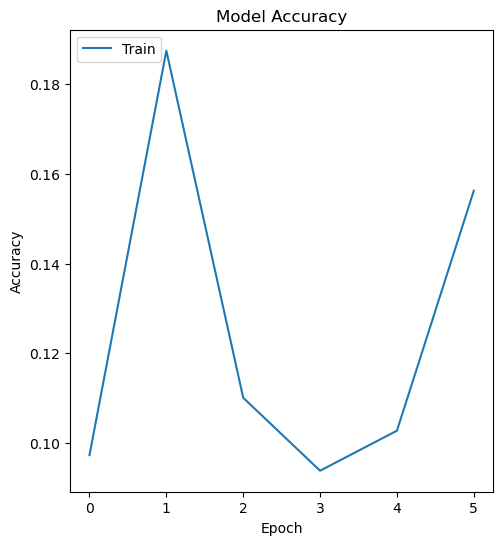

In [ ]:
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


In [ ]:

def create_cnn_model(input_shape, num_classes):
    model = Sequential([
    # First Convolutional Block
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Second Convolutional Block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Third Convolutional Block
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Fourth Convolutional Block
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Fifth Convolutional Block
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Flatten and Dense Layers
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])


    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model



In [ ]:
# Set the input shape and number of categories
input_shape = (256, 256, 3)  # 3 channels for RGB images
num_categories = 15

In [ ]:
# Create the CNN model
cnn_model = create_cnn_model(input_shape, num_categories)

In [ ]:
# Model Summary
cnn_model.summary()

In [ ]:
history = cnn_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,  # Number of batches per epoch
    epochs=10
)

##Conclusion

Conclusively, our work fills a major vacuum in the field of medical imaging by producing a large-scale, machine-human annotated chest X-ray collection similar to the industry standard "ImageNet" dataset. This is a useful tool that captures the intricacies present in actual clinical settings and the methodological difficulties radiologists encounter. We have investigated a wide variety of Convolutional Neural Network (CNN) architectures through our research, each with a unique activation function and architectural depth. Through a methodical analysis of these models' performance on our dataset, we have been able to gather important insights on how architectural design decisions affect radiology diagnostic performance.

Our results clarify how activation functions like "ReLU," "tanh," and "sigmoid" affect CNN models' performance in analyzing chest X-rays. We found that, whereas the 'ReLU' activation frequently demonstrated quicker convergence and superior performance in deeper architectures, the'sigmoid' and 'tanh' activations presented distinct difficulties concerning gradient saturation, particularly in models with more intricate architectural designs. Furthermore, it was discovered that the number of blocks in the CNN architectures had a significant factor in the model's performance, with deeper structures having a greater ability to recognize complex patterns in the data. 

After working with various activation functions we arrived at the result that ReLU activation function performed significantly better than the other functions with an accuracy of 66%

We clear the way for better diagnostic performance benchmarks in radiology by utilizing these findings. Our studies yield a thorough grasp of the advantages and disadvantages of various CNN designs as well as practical recommendations for enhancing model design approaches in the field of medical image analysis. In the future, radiologists working to improve patient outcomes and diagnostic accuracy will find great use in our annotated chest X-ray collection and the insights gathered from these experiments.